In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = 'DejaVu Serif'
plt.rcParams["mathtext.fontset"] = 'dejavuserif'
import glob
from astropy.io import fits
from astropy.table import Table, vstack
from astropy import units as u
from astropy.coordinates import SkyCoord
from scipy.spatial import cKDTree
from astropy.cosmology import LambdaCDM, z_at_value
cosmo = LambdaCDM(H0=69.6, Om0=0.286, Ode0=0.714)
h = 69.6/100

from alignment_functions.clusters import *
from geometry_functions.coordinate_functions import *
from visualization_functions import *
from alignment_functions.general_stats import *

In [2]:
scratch_path = '/pscratch/sd/c/clamman/'

### Abacus - Finding Clusters

In [5]:
hod_mock = Table.read(scratch_path+'abacus/hod_catalogs/hod_catalog_ph000_z0.5000.fits')

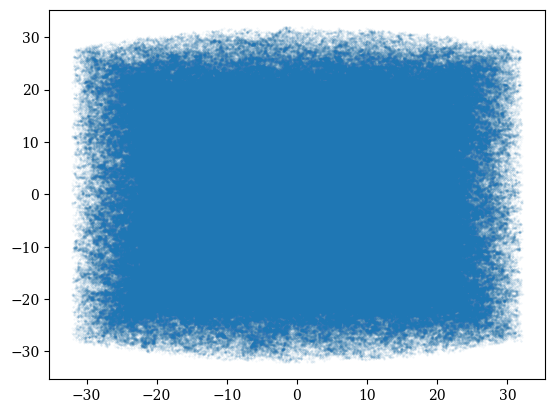

In [4]:
hod_mock['RA'] = wrap_180(hod_mock['RA'])
plt.scatter(hod_mock['RA'], hod_mock['DEC'], s=0.1, alpha=.1);

In [6]:
def find_groups_3D_tree(positions, transverse_max=0.5, los_max=5, max_n=4):
    # query nearest neighbors
    '''
    Identifies groups in a cartesian grid using a cKDTree
    Input:
    - positions: x, y, z positions in Mpc/h. 
        Assumes the observer is at the orgin and x || LOS
    - sep_max: maximum separation in Mpc/h
    - los_max: maximum separation in Mpc/h
    - max_n: maximum number of galaxies in cluster
    
    Returns: array of size (n_clusters, max_n) of indices of cluster members corresponding to points input
    '''
    tree = cKDTree(positions)

    sep_max = np.sqrt(transverse_max**2 + los_max**2)
    # dd is distances, ii is indices
    dd, ii = tree.query(positions, distance_upper_bound=sep_max, k=max_n) 
    
    # limit to pairs within transverse_max and los_max
    
    # add a row of 0s to the positions array
    positions = np.vstack((positions, [0,0,0]))
    
    # find the difference between the neighbor and the center's distance to the orgin
    dist_los = np.sqrt(positions[:,0]**2 + positions[:,1]**2 + positions[:,2]**2)
    los_seps = dist_los[ii[:,:1]] - dist_los[ii]  # neighbor - center
    # transverse separation between the galaxies relative to the orgin
    proj_sep = get_proj_dist(positions[ii[:,:1]], positions[ii], pos_obs=np.asarray([0, 0, 0]))
    
    print(np.shape(proj_sep), np.shape(los_seps), np.shape(transverse_max))
    remove = (los_seps > los_max)
    remove |= (proj_sep > transverse_max)
    positions = positions[:-1]  # remove the placeholer row
    remove[:,:1] = False # don't want to remove indices of centers
    ii[remove] = len(positions)  # where the pairs are too far, functionally remove them from the list of pairs
    dd[remove] = float('inf')
    
    # remove rows where there are no neighbors
    no_neighbors = (ii[:,1] == len(positions))
    ii = ii[~no_neighbors]
    dd = dd[~no_neighbors]
    
    # only unique clusters
    # start by sorting each row of ii
    ii.sort(axis=1)
    ii = np.unique(ii, axis=0)
    
    return ii

In [9]:
def get_proj_dist(pos1, pos2, pos_obs=np.asarray([0, 0, 0])*.7):
    '''return transverse projected distance of two positions given observer position. returns in same units as given. default is Mpc/h'''
    pos_diff = pos2 - pos1
    print(np.shape(pos_diff), np.shape(pos_obs))
    pos_mid = .5 * (pos2 + pos1)
    obs_vec = pos_mid - pos_obs
    print(np.shape(obs_vec))
    
    # project separation vector between objects onto LOS vector
    proj = np.sum(pos_diff*obs_vec, axis=1) / np.linalg.norm(obs_vec, axis=1)
    proj_v = (proj[:, np.newaxis] * obs_vec) / np.linalg.norm(obs_vec, axis=1)[:, np.newaxis]

    # subtract this vector from the separation vector
    # magnitude is projected transverse distance
    transverse_v = pos_diff - proj_v
    print(np.shape(transverse_v))
    return np.linalg.norm(transverse_v, axis=1)

In [10]:
abacus_points = np.vstack((hod_mock['x'], hod_mock['y'], hod_mock['z'])).transpose()
r_p_max = 0.5
los_max = 1
max_n = 10
cluster_ii_abacus = find_groups_3D_tree(abacus_points, transverse_max=np.sqrt(r_p_max**2 + los_max**2), los_max=los_max, max_n=max_n)

(4006392, 10, 3) (3,)
(4006392, 10, 3)


/tmp/ipykernel_1662989/4184707544.py:10: RuntimeWarning: invalid value encountered in true_divide
  proj = np.sum(pos_diff*obs_vec, axis=1) / np.linalg.norm(obs_vec, axis=1)


(4006392, 10, 3)
(4006392, 10) (4006392, 10) ()


In [11]:
cluster_member_indices = cluster_ii_abacus.flatten()
cluster_member_indices = cluster_member_indices[cluster_member_indices < len(hod_mock)]
print(len(cluster_member_indices), 'members of clusters')
cluster_member_indices = np.unique(cluster_member_indices)
print(len(cluster_member_indices), 'unique members of clusters')
#plt.scatter(hod_mock['RA'][cluster_member_indices], hod_mock['DEC'][cluster_member_indices], s=0.1, alpha=.5);
#plt.xlabel('RA')
#plt.ylabel('DEC')

0 members of clusters
0 unique members of clusters


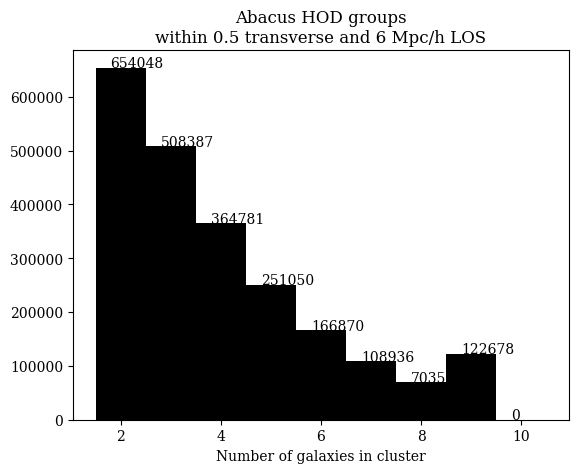

In [39]:
# number of galaxies in each cluster
# for each row in ii, count the number of unique indices
cluster_n = np.array([len(np.unique(row))-1 for row in cluster_ii_abacus])
cluster_count = plt.hist(cluster_n, bins=np.arange(1.5, max_n+1.5, 1), linewidth=2, color='k')
plt.title('Abacus HOD groups\nwithin '+str(r_p_max)+' transverse and '+str(los_max)+' Mpc/h LOS')
plt.xlabel('Number of galaxies in cluster')
# print the count in each bin above the bin on the plot
for i in range(len(cluster_count[0])):
    plt.text(cluster_count[1][i]+.3, cluster_count[0][i]+100, str(int(cluster_count[0][i])))

### Above but with DESI

In [17]:
desi_catalog = Table.read(scratch_path+'Iron_LRG_noCircles.csv') 
desi_catalog.keep_columns(['RA', 'DEC', 'Z'])

In [18]:
desi_points = get_cosmo_points(desi_catalog)

In [19]:
cluster_ii_desi = find_groups_3D_tree(desi_points)

100846 members of clusters
94810 unique members of clusters


Text(0, 0.5, 'DEC')

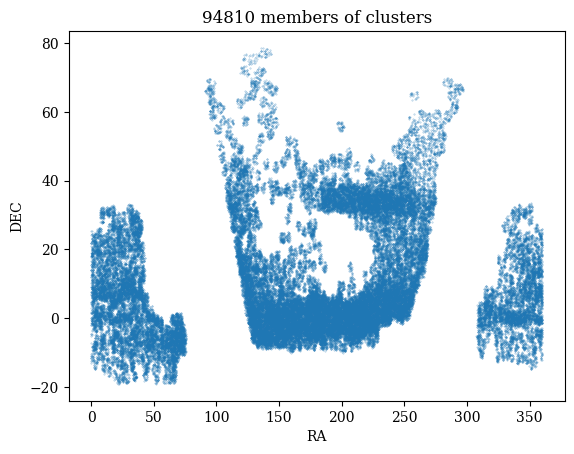

In [21]:
cluster_member_indices = cluster_ii_abacus.flatten()
cluster_member_indices = cluster_member_indices[cluster_member_indices < len(desi_catalog)]
print(len(cluster_member_indices), 'members of clusters')
cluster_member_indices = np.unique(cluster_member_indices)
print(len(np.unique(cluster_member_indices)), 'unique members of clusters')
plt.title(str(len(cluster_member_indices))+ ' members of clusters')
plt.scatter(desi_catalog['RA'][cluster_member_indices], desi_catalog['DEC'][cluster_member_indices], s=0.1, alpha=.5);
plt.xlabel('RA')
plt.ylabel('DEC')

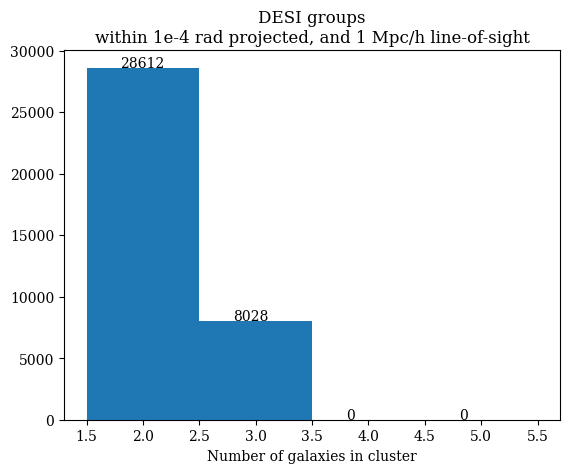

In [22]:
# number of galaxies in each cluster
# for each row in ii, count the number of unique indices
cluster_n = np.array([len(np.unique(row))-1 for row in cluster_ii_desi])
cluster_count = plt.hist(cluster_n, bins=[1.5, 2.5, 3.5, 4.5, 5.5]);
plt.title('DESI groups\nwithin 1e-4 rad projected, and 1 Mpc/h line-of-sight')
plt.xlabel('Number of galaxies in cluster')
# print the count in each bin above the bin on the plot
for i in range(len(cluster_count[0])):
    plt.text(cluster_count[1][i]+.3, cluster_count[0][i]+80, str(int(cluster_count[0][i])))

In [30]:
desi_catalog[cluster_ii_desi[((cluster_n > 3))][:,0]]

RA,DEC,Z,DIST_COMOVING
float64,float64,float64,float64
237.9018069829141,-0.12501884144141487,0.8733754273167245,2104.946352790683
336.69807846844105,1.4227162224159162,0.8356583682633141,2033.9705023149327


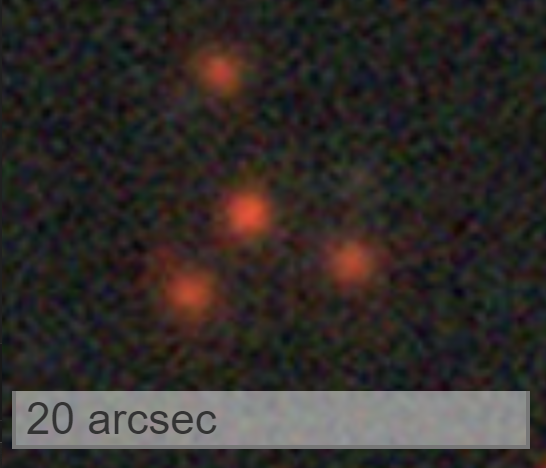

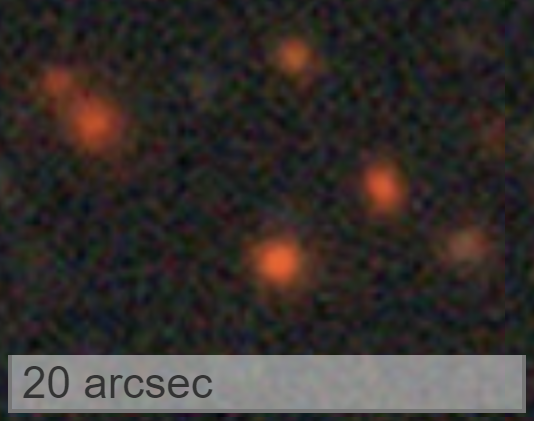

### Calculating pair alignment

In [15]:
def calculate_pair_alignment(catalog, sky_sep_max, los_max, proj_sep_max=.5, pimax=30, nbins=20, sep_type='comoving'):
    '''
    sky_sep_max in radians, los_max in Mpc/h
    for pairs relative to tracers, proj_sep_max in degrees on sky, pimax in Mpc/h
    '''
    
    # find pairs
    cluster_ii = find_cluster_2D(catalog, sky_sep_max=sky_sep_max, los_max=los_max, max_n=2)
    pairs_pa = calculate_pair_pa(catalog, cluster_ii)
    n_pairs = len(pairs_pa)
    
    # calculate alignment of pairs
    pairs_tracer_seps, pairs_tracers_paRel = calculate_rel_ang_ra_dec(pairs_pa, catalog, sep_max = deg_to_rad(proj_sep_max), sep_min=sky_sep_max, 
                                                                      max_neighbors=1000, pimax=pimax, sep_type=sep_type)
    #print(pairs_tracer_seps)
    #print(pairs_tracers_paRel)
    # binning results
    sep_bins = np.linspace(0.001, np.max(pairs_tracer_seps), nbins)
    ang_plot, ang_plot_e = bin_sum_not_scipy(pairs_tracer_seps, np.cos(2*pairs_tracers_paRel), sep_bins, statistic='mean', err=True);
    return ang_plot, ang_plot_e, n_pairs

In [22]:
#sky_sep_maxes = [.5e-4, 1e-4, 2e-4, 3e-4] # in rad
#los_maxes = [.5, 1, 2, 3] # in Mpc/h

sky_sep_maxes = [1e-3] # in rad
los_maxes = [10] # in Mpc/h

ang_plots = []
ang_plot_es = []
n_pairss = []

for j in range(len(los_maxes)):
    ang_plot, ang_plot_e, n_pairs = calculate_pair_alignment(desi_catalog, sky_sep_maxes[j], los_maxes[j], sep_type='angular')
    ang_plots.append(ang_plot)
    ang_plot_es.append(ang_plot_e)
    n_pairss.append(n_pairs)

<__array_function__ internals>:180: RuntimeWarning: Mean of empty slice
<__array_function__ internals>:180: RuntimeWarning: Degrees of freedom <= 0 for slice.


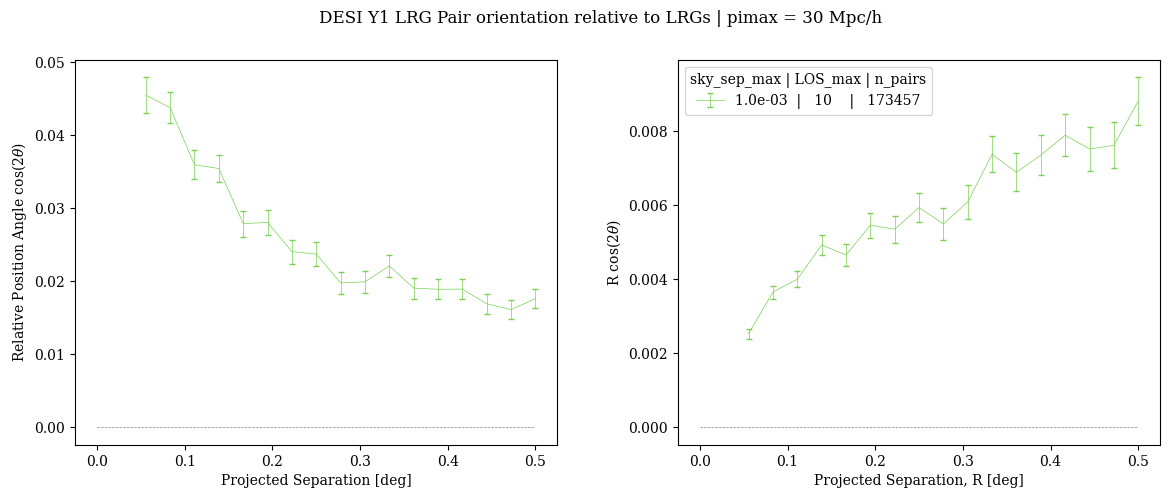

In [23]:
fig = plt.figure(figsize=(14,5))
proj_sep_max = .5
# make title of both subplots
plt.suptitle('DESI Y1 LRG Pair orientation relative to LRGs | pimax = 30 Mpc/h')
plt.subplots_adjust(wspace=.25)

plt.subplot(121)
plt.plot([0, proj_sep_max], [0, 0], 'k--', alpha=.5, linewidth=.5)
plt.xlabel('Projected Separation [deg]')
plt.ylabel(r'Relative Position Angle cos(2$\theta$)')

plt.subplot(122)
plt.plot([0, proj_sep_max], [0, 0], 'k--', alpha=.5, linewidth=.5)
plt.xlabel('Projected Separation, R [deg]')
plt.ylabel(r'R cos(2$\theta$)');

# make list of 5 gradient colors
colors = plt.cm.viridis_r(np.linspace(0.2, 1, 5))

nbins=20
xvalues = np.linspace(0, proj_sep_max, nbins-1)

plot_args = {'linewidth':.5, 'capsize':2}

for j in range(len(los_maxes)):
    
    plt.subplot(121)
    plt.errorbar(xvalues, ang_plots[j], yerr=ang_plot_es[j], color=colors[j], **plot_args)
    
    plt.subplot(122)
    plt.errorbar(xvalues, xvalues*ang_plots[j], yerr=xvalues*ang_plot_es[j], 
                label = '{}  |   {:<5} |   {}'.format("{:.1e}".format(sky_sep_maxes[j]), los_maxes[j], n_pairss[j]), color=colors[j], **plot_args)
    
    
plt.legend(title='sky_sep_max | LOS_max | n_pairs');
#fig.savefig(scratch_path+'plots_to_download/DESI_Y1_LRG_pair_alignment_psep.png', dpi=300, bbox_inches='tight')

^ this is weird because we find the pairs in angular sep. I think. do when less tierd.

## above but with abacus

In [5]:
sky_sep_maxes = [.5e-4, 1e-4, 2e-4, 3e-4]
los_maxes = [.5, 1, 2, 3]


hod_paths = glob.glob(scratch_path+'abacus/hod_catalogs/*.fits')

ap_agg = []
ape_agg = []
n_pairs_total = np.asarray([0]*len(los_maxes))

for hp in hod_paths:
    print('working on ', hp)
    hod_mock = Table.read(hp)
    hod_mock['DIST_COMOVING'] = cosmo.comoving_distance(hod_mock['Z_withRSD']).value*h
    hod_mock['Z'] = hod_mock['Z_withRSD']

    ang_plots = []
    ang_plot_es = []
    n_pairss = []

    for j in range(len(los_maxes)):
        ang_plot, ang_plot_e, n_pairs = calculate_pair_alignment(hod_mock, sky_sep_max= sky_sep_maxes[j], los_max = los_maxes[j])
        ang_plots.append(ang_plot)
        ang_plot_es.append(ang_plot_e)
        n_pairss.append(n_pairs)
    
    ap_agg.append(ang_plots)
    ape_agg.append(ang_plot_es)
    n_pairs_total += np.asarray(n_pairss)

working on  /pscratch/sd/c/clamman/abacus/hod_catalogs/hod_catalog_ph000_z0.5000.fits
working on  /pscratch/sd/c/clamman/abacus/hod_catalogs/hod_catalog_ph008_z0.5000.fits
working on  /pscratch/sd/c/clamman/abacus/hod_catalogs/hod_catalog_ph020_z0.5000.fits
working on  /pscratch/sd/c/clamman/abacus/hod_catalogs/hod_catalog_ph024_z0.5000.fits
working on  /pscratch/sd/c/clamman/abacus/hod_catalogs/hod_catalog_ph019_z0.5000.fits
working on  /pscratch/sd/c/clamman/abacus/hod_catalogs/hod_catalog_ph018_z0.5000.fits
working on  /pscratch/sd/c/clamman/abacus/hod_catalogs/hod_catalog_ph014_z0.5000.fits
working on  /pscratch/sd/c/clamman/abacus/hod_catalogs/hod_catalog_ph021_z0.5000.fits
working on  /pscratch/sd/c/clamman/abacus/hod_catalogs/hod_catalog_ph009_z0.5000.fits
working on  /pscratch/sd/c/clamman/abacus/hod_catalogs/hod_catalog_ph003_z0.5000.fits
working on  /pscratch/sd/c/clamman/abacus/hod_catalogs/hod_catalog_ph011_z0.5000.fits
working on  /pscratch/sd/c/clamman/abacus/hod_catalogs

In [13]:
ang_plots = np.mean(np.asarray(ap_agg), axis=0)
ang_plot_es = np.std(np.asarray(ap_agg), axis=0)/np.sqrt(len(ap_agg))
#ang_plot_es = np.sqrt(np.sum(np.asarray(ape_agg)**2, axis=0))/np.sqrt(len(ape_agg))

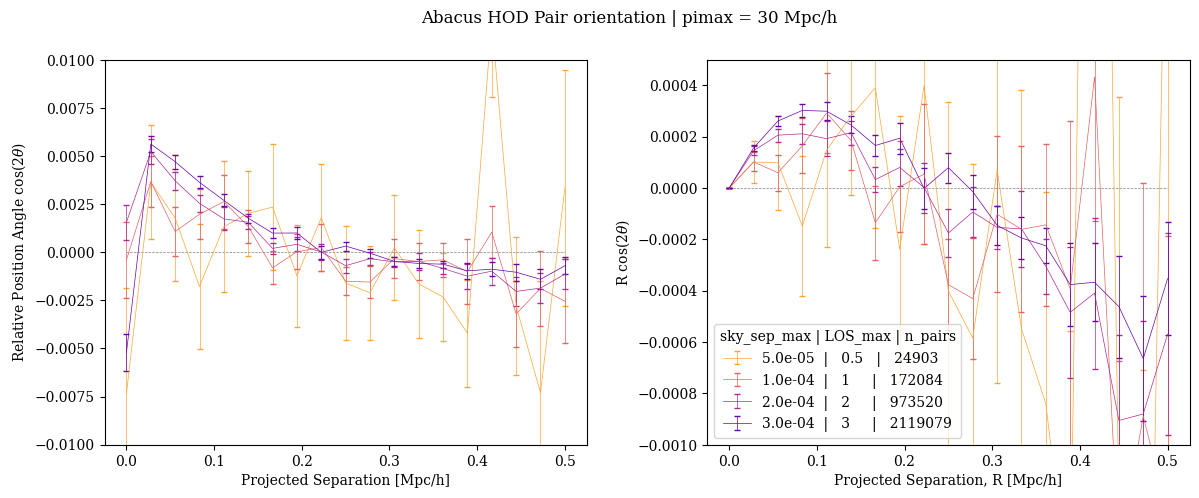

In [19]:
fig = plt.figure(figsize=(14,5))
proj_sep_max = .5
# make title of both subplots
plt.suptitle('Abacus HOD Pair orientation | pimax = 30 Mpc/h')
plt.subplots_adjust(wspace=.25)

plt.subplot(121)
plt.plot([0, .5], [0, 0], 'k--', alpha=.5, linewidth=.5)
plt.xlabel('Projected Separation [Mpc/h]')
plt.ylabel(r'Relative Position Angle cos(2$\theta$)')
plt.ylim(-.01, .01)

plt.subplot(122)
plt.plot([0, .5], [0, 0], 'k--', alpha=.5, linewidth=.5)
plt.xlabel('Projected Separation, R [Mpc/h]')
plt.ylabel(r'R cos(2$\theta$)');
plt.ylim(-.001, .0005)

# make list of 5 gradient colors
colors = plt.cm.plasma_r(np.linspace(0.2, 1, 5))

nbins=20
xvalues = np.linspace(0, proj_sep_max, nbins-1)

plot_args = {'linewidth':.5, 'capsize':2}

for j in range(len(los_maxes)):
    
    plt.subplot(121)
    plt.errorbar(xvalues, ang_plots[j], yerr=ang_plot_es[j], color=colors[j], **plot_args)
    
    plt.subplot(122)
    plt.errorbar(xvalues, xvalues*ang_plots[j], yerr=xvalues*ang_plot_es[j], 
                label = '{}  |   {:<5} |   {}'.format("{:.1e}".format(sky_sep_maxes[j]), los_maxes[j], n_pairs_total[j]), color=colors[j], **plot_args)
    
    
plt.legend(title='sky_sep_max | LOS_max | n_pairs');
fig.savefig(scratch_path+'plots_to_download/abacusHOD_pair_alignment_betterrr.png', dpi=300, bbox_inches='tight')

--------------

In [14]:
def calculate_rel_ang_ra_dec(query_catalog, catalog, sep_max = deg_to_rad(.5), 
                             sep_min = False, max_neighbors=100, pimax=30, sep_type='angular'):
    
    matches_ii = find_neighbors(query_catalog, catalog, sep_max, sep_min=sep_min, k=max_neighbors)
    # make arrays of centers and neighbors, with identical shapes
    cluster_centers_i = np.repeat(np.arange(len(query_catalog)), max_neighbors-1).ravel()
    cluster_neighbors_i = matches_ii[:,1:].ravel()
    
    # removing places where no neighbor was found in the tree
    neighbor_exists = (cluster_neighbors_i!=len(catalog))
    cluster_centers_i = cluster_centers_i[neighbor_exists]; cluster_neighbors_i = cluster_neighbors_i[neighbor_exists]
    
    centers_m = query_catalog[cluster_centers_i]
    neighbors_m = catalog[cluster_neighbors_i]
    
    # limit to pimax
    i_keep = np.abs(centers_m['DIST_COMOVING'] - neighbors_m['DIST_COMOVING']) < pimax
    centers_m = centers_m[i_keep];  neighbors_m = neighbors_m[i_keep]
    
    # get sep and relative position angle
    if sep_type=='angular':
        sep, pa = get_sep_pa(centers_m['RA'], centers_m['DEC'], neighbors_m['RA'], neighbors_m['DEC'])
        pa_rel = centers_m['THETA'] - pa
        return sep.to(u.deg).value, pa_rel
        
    elif sep_type=='comoving':
        sep, pa = get_cosmo_psep_pa(centers_m['RA'], centers_m['DEC'], 
                                    neighbors_m['RA'], neighbors_m['DEC'], centers_m['Z'], neighbors_m['Z']) 
        pa_rel = centers_m['THETA'] - pa
        return sep.to(u.Mpc*u.rad).value * .7, pa_rel

In [13]:
def bin_sum_not_scipy(x_values, y_values, x_bins, statistic='sum', err=False):
    '''
    alternative to scipy, which sometimes has issues handling binnind with very non-uniform footprints
    x_bins = bin edges
    '''
    inds = np.digitize(x_values, x_bins)
    
    if statistic=='sum':
        y_sums = []
        y_errs = []
        for ind in range(len(x_bins)-1):
            y_bin = y_values[(inds==(ind+1))]
            y_sums.append(np.sum(y_bin))#; y_std.append(np.std(y_bin))
            y_errs.append(np.std(y_bin) / np.sqrt(len(y_bin)))
        if err==True:
            return np.asarray(remove_astropyu(y_sums)), np.asarray(remove_astropyu(y_errs))
        else:
            return np.asarray(remove_astropyu(y_sums))#, np.asarray(y_std)
    
    if statistic=='mean':
        y_sums = []
        y_errs = []
        for ind in range(len(x_bins)-1):
            y_bin = y_values[(inds==(ind+1))]
            y_sums.append(np.nanmean(y_bin))#; y_std.append(np.std(y_bin))
            y_errs.append(np.nanstd(y_bin) / np.sqrt(len(y_bin)))
        if err==True:
            return y_sums, y_errs
        else:
            return y_sums

#### Clusters relative to clusters

In [6]:
def calculate_rel_ang_cartesian(all_points, tree, center_points, sep_vectors, sep_max = 30, max_neighbors=100, pimax=30):
    '''no sky projection. sep_max and pimax in units of Mpc/h'''
    
    ci, ni, dd = find_pairs(center_points, tree, sep_max, k=max_neighbors, double=False, return_sep=True)
    
    print(np.shape(ci), np.shape(ni), np.shape(dd), np.shape(sep_vectors))
    # limit to pimax and ones with some separation
    to_keep = np.abs(all_points[ci,0] - all_points[ni,0]) < pimax
    to_keep &= (dd > 2)
    ci = ci[to_keep]; ni = ni[to_keep]
    
    # get projected sep and position angle
    proj_seps = np.sqrt((all_points[ci,1]-all_points[ni,1])**2 + (all_points[ci,2] - all_points[ni,2])**2)
    pa = np.arctan2((all_points[ci,2] - all_points[ni,2]), (all_points[ci,1]-all_points[ni,1]))
    orientation_angle = np.arctan2(sep_vectors[:,2], sep_vectors[:,1])[to_keep]
    pa_rel = orientation_angle - pa
    
    return proj_seps, np.abs(pa_rel)

In [7]:
proj_sep_max = 100
pimax = 40
cluster_tree = cKDTree(center_points)
cluster_seps, cluster_pa_rel = calculate_rel_ang_cartesian(abacus_catalog['x_L2com'], cluster_tree, center_points, sep_vectors, sep_max = proj_sep_max, max_neighbors=1000, pimax=pimax)

(20551918,) (20551918,) (20551918,) (197351, 3)


IndexError: boolean index did not match indexed array along dimension 0; dimension is 197351 but corresponding boolean dimension is 20551918

In [ ]:
nbins = 30
sep_bins = np.linspace(0, proj_sep_max, nbins)
ang_plot, ang_plot_e = bin_sum_not_scipy(cluster_seps, np.cos(2*cluster_pa_rel), sep_bins, statistic='mean', err=True)

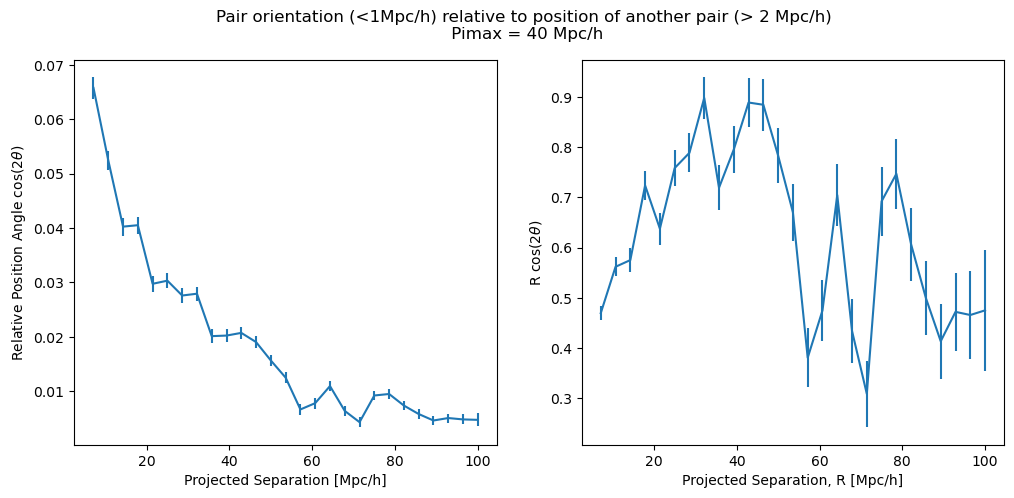

In [18]:
fig = plt.figure(figsize=(12,5))

# make title of both subplots
plt.suptitle('Abacus Pair orientation (<1Mpc/h) relative to position of another pair (> 2 Mpc/h)\n Pimax = ' + str(pimax) + ' Mpc/h')

lowerlim=2
xvalues = np.linspace(0, proj_sep_max, nbins-1)[lowerlim:]
yvalues = ang_plot[lowerlim:]

plt.subplot(121)
plt.errorbar(xvalues, yvalues, yerr=ang_plot_e[lowerlim:])
plt.xlabel('Projected Separation [Mpc/h]')
plt.ylabel(r'Relative Position Angle cos(2$\theta$)')

plt.subplot(122)
plt.errorbar(xvalues, xvalues*yvalues, yerr=xvalues*ang_plot_e[lowerlim:])
plt.xlabel('Projected Separation, R [Mpc/h]')
plt.ylabel(r'R cos(2$\theta$)');


### DESI

In [11]:
desi_catalog = Table.read('/global/cfs/cdirs/desi/users/clamman/catalogs/y1_comoving_coordinates.fits')

In [16]:
desi_catalog['Z'] = z_at_value(cosmo.comoving_distance, desi_catalog['distMpc']*u.Mpc)
desi_catalog['x_L2com'] = np.dstack(desi_catalog['X'], desi_catalog['Y'], desi_catalog['Z'])[0]

In [1]:
tree = cKDTree(desi_catalog['x_L2com'])

NameError: name 'cKDTree' is not defined

In [ ]:
center_points, sep_vectors = find_projected_pairs_cartesian(desi_catalog, tree, sep_max=1, n_in_cluster=2)

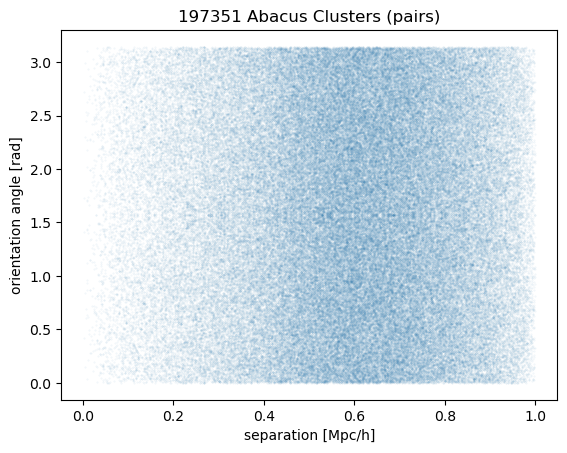

In [ ]:
plt.title(str(len(center_points)) + ' DESI Clusters (pairs)')
plt.xlabel('separation [Mpc/h]'); plt.ylabel('orientation angle [rad]')
plt.scatter(np.sqrt(sep_vectors[:,1]**2 + sep_vectors[:,2]**2), np.abs(np.arctan2(sep_vectors[:,2], sep_vectors[:,1])), s=.1, alpha=.1);

#### DESI Clusters relative to clusters

In [ ]:
def calculate_rel_ang_cartesian(center_points, tree, sep_vectors, sep_max = 30, max_neighbors=100, pimax=30):
    '''no sky projection. sep_max and pimax in units of Mpc/h'''
    
    ci, ni, dd = find_pairs(center_points, tree, sep_max, k=max_neighbors, double=False, return_sep=True)
    
    # limit to pimax and ones with some separation
    to_keep = np.abs(center_points[ci,0] - center_points[ni,0]) < pimax
    to_keep &= (dd > 2)
    ci = ci[to_keep]; ni = ni[to_keep]
    
    # get projected sep and position angle
    proj_seps = np.sqrt((center_points[ci,1]-center_points[ni,1])**2 + (center_points[ci,2] - center_points[ni,2])**2)
    pa = np.arctan2((center_points[ci,2] - center_points[ni,2]), (center_points[ci,1]-center_points[ni,1]))
    orientation_angle = np.arctan2(sep_vectors[ci,2], sep_vectors[ci,1])
    pa_rel = orientation_angle - pa
    
    return proj_seps, np.abs(pa_rel)

In [ ]:
proj_sep_max = 100
pimax = 40
cluster_tree = cKDTree(center_points)
cluster_seps, cluster_pa_rel = calculate_rel_ang_cartesian(desi_catalog['x_L2com'], cluster_tree, center_points, sep_vectors, sep_max = proj_sep_max, max_neighbors=1000, pimax=pimax)

(20551918,) (20551918,) (20551918,) (197351, 3)


IndexError: boolean index did not match indexed array along dimension 0; dimension is 197351 but corresponding boolean dimension is 20551918

In [ ]:
nbins = 30
sep_bins = np.linspace(0, proj_sep_max, nbins)
ang_plot, ang_plot_e = bin_sum_not_scipy(cluster_seps, np.cos(2*cluster_pa_rel), sep_bins, statistic='mean', err=True)

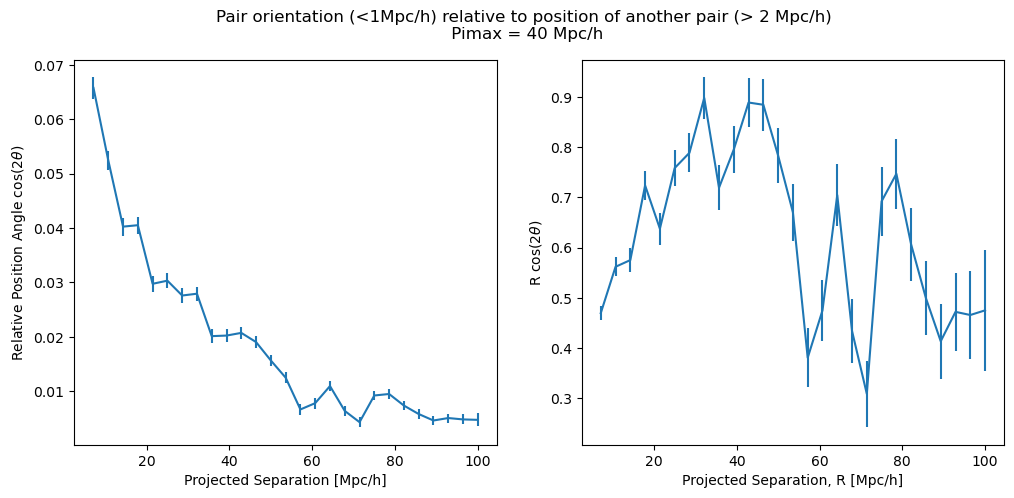

In [ ]:
fig = plt.figure(figsize=(12,5))

# make title of both subplots
plt.suptitle('DESI Y1 Pair orientation (<1Mpc/h) relative to position of another pair (> 2 Mpc/h)\n Pimax = ' + str(pimax) + ' Mpc/h')

lowerlim=2
xvalues = np.linspace(0, proj_sep_max, nbins-1)[lowerlim:]
yvalues = ang_plot[lowerlim:]

plt.subplot(121)
plt.errorbar(xvalues, yvalues, yerr=ang_plot_e[lowerlim:])
plt.xlabel('Projected Separation [Mpc/h]')
plt.ylabel(r'Relative Position Angle cos(2$\theta$)')

plt.subplot(122)
plt.errorbar(xvalues, xvalues*yvalues, yerr=xvalues*ang_plot_e[lowerlim:])
plt.xlabel('Projected Separation, R [Mpc/h]')
plt.ylabel(r'R cos(2$\theta$)');


#### Clusters relative to galaxies

In [ ]:
proj_sep_max = 100
pimax = 40
cluster_seps, cluster_pa_rel = calculate_rel_ang_cartesian(center_points, tree, sep_vectors, sep_max = proj_sep_max, max_neighbors=1000, pimax=pimax)

In [ ]:
nbins = 30
sep_bins = np.linspace(0, proj_sep_max, nbins)
ang_plot, ang_plot_e = bin_sum_not_scipy(cluster_seps, np.cos(2*cluster_pa_rel), sep_bins, statistic='mean', err=True)

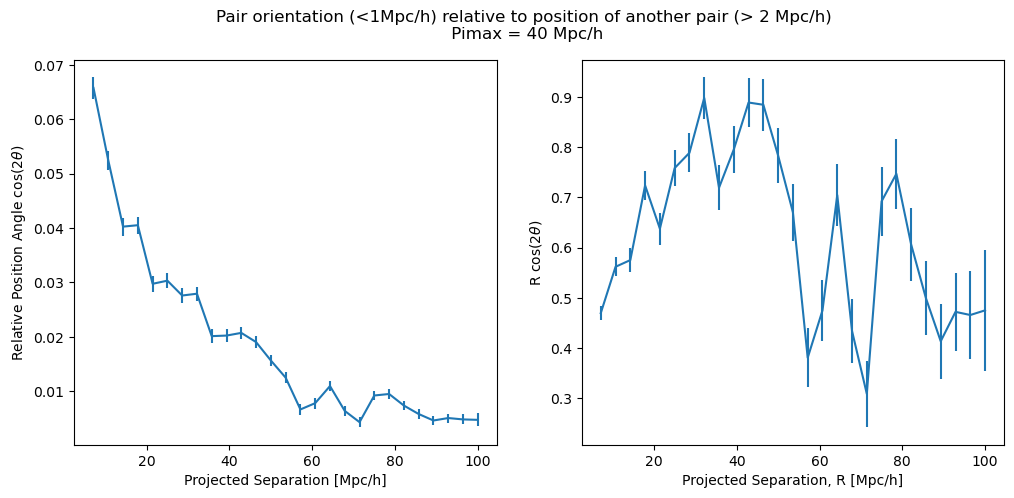

In [ ]:
fig = plt.figure(figsize=(12,5))

# make title of both subplots
plt.suptitle('Pair orientation (<1Mpc/h) relative to position of another pair (> 2 Mpc/h)\n Pimax = ' + str(pimax) + ' Mpc/h')

lowerlim=2
xvalues = np.linspace(0, proj_sep_max, nbins-1)[lowerlim:]
yvalues = ang_plot[lowerlim:]

plt.subplot(121)
plt.errorbar(xvalues, yvalues, yerr=ang_plot_e[lowerlim:])
plt.xlabel('Projected Separation [Mpc/h]')
plt.ylabel(r'Relative Position Angle cos(2$\theta$)')

plt.subplot(122)
plt.errorbar(xvalues, xvalues*yvalues, yerr=xvalues*ang_plot_e[lowerlim:])
plt.xlabel('Projected Separation, R [Mpc/h]')
plt.ylabel(r'R cos(2$\theta$)');
